# Put it all together
- Pull a video
- Loop through frames.
- Determine where the gt_chessboard is (if it is) in the frame.
- Extract the GT board
    - See if it changed?
- Replace the gt board with filler (first frame?)
- Store FEN until the final frame
- Identify when the gameplay portion is over and quit

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext lab_black

In [187]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../src/")
import chess
from chess import svg

# from video_pull import pull_video
from tqdm import tqdm

import matplotlib.pylab as plt
import cv2
from cairosvg import svg2png
from utils import get_uci

In [16]:
from label_extract import VideoBoardExtractor

vbe = VideoBoardExtractor(
    "../data/CoffeeChess/FKEDBYjfS7g.mp4",
    gt_board_loc=[20, 415, 445, 835],
    predict_fen=True,
    store_gt_boards=True,
    store_masks=True,
)

vbe.load_videocap()
vbe.process_video(30 * 60 * 5)

	 Loading model '../tensorflow_chessbot/saved_models/frozen_graph.pb'
	 Model restored.


100%|█████████▉| 8999/9000 [03:52<00:00, 38.69it/s] 


# Plot the colors over the duration of the video

In [17]:
df_colors = pd.DataFrame(vbe.avg_frame_color).T

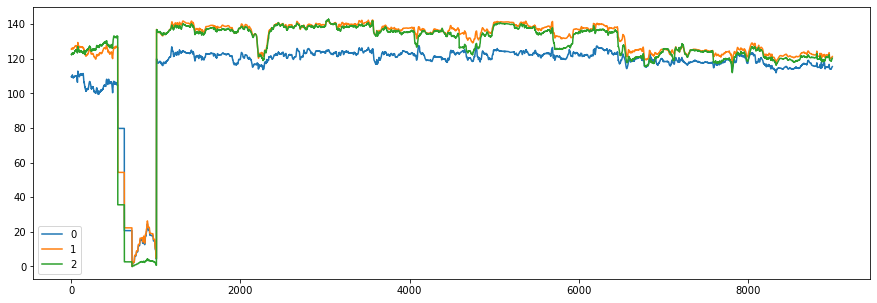

In [18]:
df_colors.plot(figsize=(15, 5))

## Show the first frame

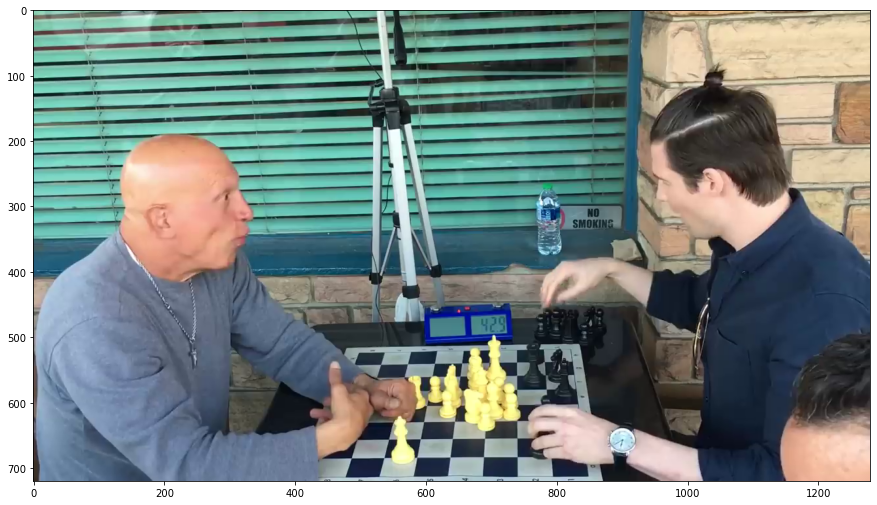

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(vbe.first_frame_img)

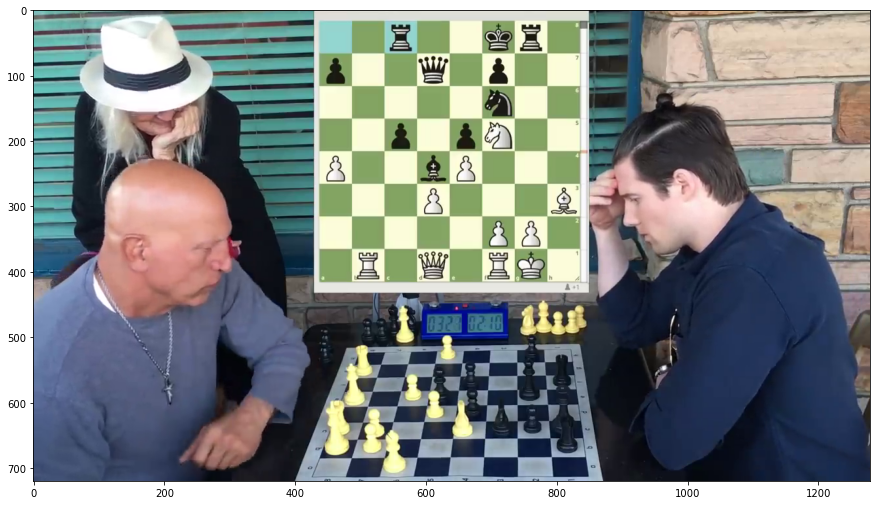

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(vbe.this_frame_img)

# Get FEN Positions

In [106]:
fen_df = pd.DataFrame(vbe.fens.items(), columns=["frame", "fen"])

fen_df["frame_count"] = fen_df["fen"].map(fen_df["fen"].value_counts().to_dict())
fen_df = (
    fen_df.query("frame_count > 4")
    .drop_duplicates(subset=["fen"])
    .reset_index(drop=True)
    .copy()
)

In [ ]:
for frame in fen_df["frame"].unique():
    # Looping through frames where the predicted
    # FEN position has changed
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Show the image with the GT board removed
    axs[0].imshow(vbe.masks[frame])
    # Actual GT board pulled from the video
    axs[1].imshow(vbe.gt_boards[frame])
    fen = vbe.fens[frame]
    fig.suptitle(f"Frame {frame}\n{fen}", fontsize=20, y=1.15)
    # Display the predicted FEN
    board = chess.Board(vbe.fens[frame])
    boardsvg = chess.svg.board(board=board)
    boardpng = svg2png(boardsvg)
    fen_png = cv2.imdecode(np.frombuffer(boardpng, np.uint8), -1)
    fen_png = cv2.cvtColor(fen_png, cv2.COLOR_BGR2RGB)
    axs[2].imshow(fen_png)
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    axs[0].set_title("masked image")
    axs[1].set_title("gt board from video")
    axs[2].set_title("predicted position")
    plt.tight_layout()
    plt.show()

# Loop Through Moves in Chess Board Object

In [186]:
board.move_stack

[Move.from_uci('c2c4'),
 Move.from_uci('b8c6'),
 Move.from_uci('b1c3'),
 Move.from_uci('e7e5'),
 Move.from_uci('e2e4'),
 Move.from_uci('f8c5'),
 Move.from_uci('d2d3'),
 Move.from_uci('d7d6'),
 Move.from_uci('g1f3'),
 Move.from_uci('c8g4'),
 Move.from_uci('h2h3'),
 Move.from_uci('g4h5'),
 Move.from_uci('c1e3'),
 Move.from_uci('c5b6'),
 Move.from_uci('f1e2'),
 Move.from_uci('h5f3'),
 Move.from_uci('e2f3'),
 Move.from_uci('c6d4'),
 Move.from_uci('e3d4'),
 Move.from_uci('b6d4'),
 Move.from_uci('c3a4'),
 Move.from_uci('d8d7'),
 Move.from_uci('b2b3'),
 Move.from_uci('b7b5'),
 Move.from_uci('c4b5'),
 Move.from_uci('d7b5')]

In [184]:
board = chess.Board("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR")
move_count = 0
succ_fen = None
for fen in fen_df["fen"].values:
    if succ_fen == fen:
        continue
    new_board = chess.Board(fen)
    if move_count % 2 == 0:
        who_moved = "w"
    else:
        who_moved = "b"

    move = get_uci(board, new_board, who_moved)
    try:
        # if True:
        board.push_san(move)
        succ_fen = fen
        move_count += 1
    except Exception as e:
        print(f"failed move {move_count} with exception {e}")
        print(fen)
        pass
    # break

# board1 = chess.Board(fen_df["fen"].values[0])
# board2 = chess.Board(fen_df["fen"].values[1])
# move = get_uci(board0, board1, "w")

# move2 = get_uci(board1, board2, "b")

failed move 16 with exception illegal san: 'e2' in r2qk1nr/ppp2ppp/1bnp4/4p3/2P1P3/2NPBb1P/PP2BPP1/R2QK2R w - - 0 9
r2qk1nr/ppp2ppp/1bnp4/4p3/2P1P3/2NPBb1P/PP3PP1/R2QK2R
failed move 25 with exception invalid san: ''
r3k1nr/p1pq1ppp/3p4/1P2p3/N2bP3/1P1P1B1P/P4PP1/R2QK2R
failed move 25 with exception illegal san: 'd7' in r3k1nr/p1pq1ppp/3p4/1P2p3/N2bP3/1P1P1B1P/P4PP1/R2QK2R b - - 0 13
r3k1nr/p1p2ppp/3p4/1P2p3/N2bP3/1P1P1B1P/P4PP1/R2QK2R
failed move 26 with exception invalid san: 'h1g1f1e1'
r3k1nr/p1p2ppp/3p4/1q2p3/N2bP3/1P1P1B1P/P4PP1/R2Q1RK1
failed move 26 with exception invalid san: 'h1g1f1e1f6g8'
r3k2r/p1p2ppp/3p1n2/1q2p3/N2bP3/1P1P1B1P/P4PP1/R2Q1RK1
failed move 26 with exception invalid san: 'h1g1f1e1a1f6g8'
r3k2r/p1p2ppp/3p1n2/1q2p3/N2bP3/1P1P1B1P/P4PP1/3Q1RK1
failed move 26 with exception invalid san: 'h1g1f1e1b1a1f6g8'
r3k2r/p1p2ppp/3p1n2/1q2p3/N2bP3/1P1P1B1P/P4PP1/1R1Q1RK1
failed move 26 with exception invalid san: 'h1g1f1e1b1a1c5f6c7g8'
r3k2r/p4ppp/3p1n2/1qp1p3/N2bP3/1P1P1B1P/P4

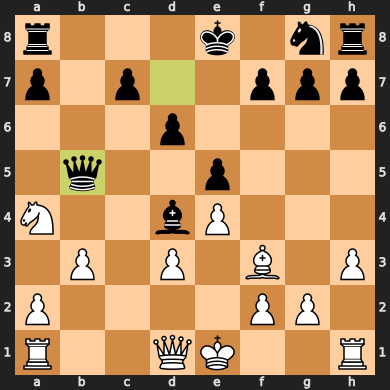

In [182]:
board

In [183]:
# chess.Board(fen)

In [115]:
8663 / 30 / 60

4.812777777777778

In [146]:
# chess.Board("2r2kr1/p2q1p2/5n2/2p1pN2/P2bP3/3P3B/5PP1/1R1Q1RK1")

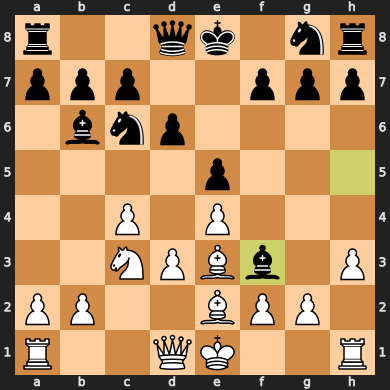

In [163]:
board

In [87]:
# svg2png(bytestring=boardsvg,write_to='temp_out.png')
# b.set_fen(vbe.fens[1116])